# Dask DataFrame

pandas 已经成为 DataFrame 的标准，但无法利用多核和集群，Dask DataFrame 试图解决 pandas 并行计算的问题。Dask DataFrame 尽量提供与 pandas 一致的 API，但使用起来，Dask DataFrame 仍有很多不同。Dask DataFrame 将大数据切分成小的 Partition，每个 Partition 是一个 pandas DataFrame。Dask 会把 DataFrame 的元数据记录下来，存储在 \_meta 中。多个 Partition 的信息存储在内置变量 partitions 里和 divisions 里。Dask 用 Task Graph 管理计算图。对于用户来说，其实不需要太深入理解 Dask DataFrame 具体如何实现的，只需要调用跟 pandas 类似的上层 API。本章假设用户已经了解并熟悉 pandas，并重点讨论 Dask DataFrame 与 pandas 的区别。

# 读写数据

Dask DataFrame 支持 pandas 中几乎所有的数据读写操作，包括从本地、NFS、HDFS 或 S3 上读写文本文件、Parquet、HDF、JSON 等格式的文件。 下表是几个常见的读写操作。

||CSV|Parquet|HDF
|---|---|---|---|
|读|read_csv()|read_parquet()|read_hdf()
|写|to_csv()|to_parquet()|to_hdf()

## 文件系统

当我们在使用 Dask 集群读写数据时，数据源应该存储在 NFS、HDFS、S3 这种共享文件系统，这样所有 Dask Worker 都能访问该数据。

业内经常使用文件系统前缀（Scheme）来标识不同的文件系统，并调用不同的库来读写文件系统。下表是几个 Scheme 例子。一个数据集地址，应该是一个统一资源标识（Uniform Resource Identifier，URI），URI 包括 Scheme 和具体的地址，URI 模板为：scheme://path/to/data。比如：file:///tmp/tripdata.parquet 或 s3://tmp/tripdata.parquet。

||本地|S3|HDFS
|---|---|---|---|
|Scheme|file://|s3://|hdfs://

如果数据集地址没有加任何 Scheme，会假设是本地可访问的文件系统，即该计算节点可以直接读写和访问的文件系统。比如，网络文件系统（Network File System，NFS）是分布式文件系统，假如被挂载到多个计算节点的 /mnt/nfs 目录，使用 Dask 读写该目录时，可直接使用 /mnt/nfs 这个目录。

HDFS 和 S3 这样共享文件系统，在企业或组织中被多人共享，因此经常有用户验证的环节，以做好用户之间的数据隔离，避免用户互相修改或删除数据。不同的文件系统有自己的用户验证的方式，比如，S3 用户需要提供令牌（Token），Token 可以通过 read_*() 和 to_*() (包括 read_csv()、read_parquet、to_parquet() 等方法) 的 storage_options 参数传递进来。如果你对用户验证不熟悉，应咨询组织中负责运维管理的同事。

# 数据切分与并行读取

## 案例：飞机起降数据

飞机起降数据集由多个逗号分隔的数值（Comma-Separated Values，CSV）文件组成，每个文件对应一个年份，我们读取多个 CSV，来展示 Dask DataFrame 与 pandas 的区别。

In [10]:
import os
import glob

import sys
sys.path.append("..")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

file_path = os.path.join("../../../../data/20.others/nyc_flights/", "nyc-flights", "*.csv")

In [4]:
import dask
dask.config.set({'dataframe.query-planning': False})
import dask.dataframe as dd
import pandas as pd
from dask.distributed import LocalCluster, Client

cluster = LocalCluster()
client = Client(cluster)

pandas 和 Dask DataFrame 都提供了 read_csv() 方法，用来读取 CSV 文件。Dask 的 read_csv() 参数与 pandas 几乎一致，可以参考 pandas 的 read_csv()。比如在这个例子中，原始数据有很多列，其中前三列分别为，年：Year，月：Month，日：DayofMonth，read_csv() 方法的 parse_dates 参数将这三列解析为时间 datetime64 类型，并生成一个新的列 Date。

In [12]:
ddf = dd.read_csv(file_path, parse_dates={'Date': [0, 1, 2]})

这里的 file_path 是 *.csv 的形式，匹配所有以 csv 结尾的文件；而 pandas 的 read_csv() 只能读取单个文件，并不支持 *.csv 这样的通配符。如果想用 pandas 读文件夹下面的所有以 csv 结尾的文件，应该：

In [14]:
file_list = glob.glob(file_path)
data = []

for p in file_list:
    df = pd.read_csv(p, parse_dates={'Date': [0, 1, 2]})
    data.append(df)

pdf = pd.concat(data)

In [13]:
ddf.head(3)

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1991-01-08,2,1215.0,1215,1340.0,1336,US,121,NaN,85.0,...,NaN,4.0,0.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1991-01-09,3,1215.0,1215,1353.0,1336,US,121,NaN,98.0,...,NaN,17.0,0.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1991-01-10,4,1216.0,1215,1332.0,1336,US,121,NaN,76.0,...,NaN,-4.0,1.0,EWR,PIT,319.0,NaN,NaN,0,0


In [15]:
pdf.head(3)

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1991-01-08,2,1215.0,1215,1340.0,1336,US,121,NaN,85.0,...,NaN,4.0,0.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1991-01-09,3,1215.0,1215,1353.0,1336,US,121,NaN,98.0,...,NaN,17.0,0.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1991-01-10,4,1216.0,1215,1332.0,1336,US,121,NaN,76.0,...,NaN,-4.0,1.0,EWR,PIT,319.0,NaN,NaN,0,0


这里体现出 Dask DataFrame 与 pandas 的区别：Dask DataFrame 接受 \*.csv 这样的通配符，可以批量读取文件夹下所有的以 csv 结尾的文件。Dask DataFrame 在实现时，先对 \*.csv 目录进行了遍历，了解到目录下一共有多少个 CSV 文件，并在构建 Task Graph 时，根据文件数量，并行地启动多个 pandas 进程。

ddf.visualize() 将 Task Graph 进行了可视化，可以看到：目录下有 m 个 CSV 文件，在 Task Graph 中生成 m 个 read_csv() 子图，执行时并行地启动 m 个 pandas 的 read_csv()；或者说，每个 CSV 文件对应一个 Partition。根据文件数量构建 Task Graph 中的并行粒度是一种最简单的图生成方式。

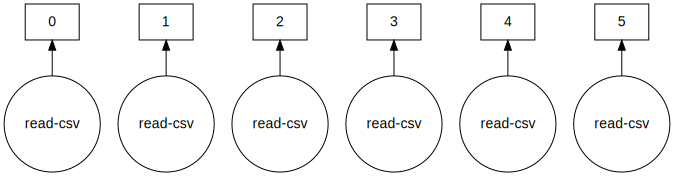

In [16]:
ddf.visualize(filename="../images/nyc-flights-graph", format="svg")

这个例子中，Dask 根据文件数量来确定 Partition 的数量。之前提到，数据切分得过细或者过粗都不是最好的。对于所有可能的场景来说，单纯根据文件数量来确定切分为多少个 Partition 的方式并不一定是最优的：因为如果很多小文件，切分粒度会过细；或者如果是单个大文件，切分粒度过粗，可能导致 OOM。这两种极端情况下生成的 Task Graph 和并行粒度都不是最优的。所以，Dask DataFrame 的 read_csv() 提供了自定义每个 Partition 大小的参数 blocksize，单个 Partition 的大小不会超过 blocksize。如果用户没有显式设置 `blocksize`，Dask DataFrame 会根据探测到的计算资源情况来确定 blocksize，最大不超过 64MB。